In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import preprocessing
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn import svm
from sklearn.feature_selection import chi2
from sklearn.feature_selection import SelectKBest
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
from sklearn.svm import SVC
from scipy.stats import f_oneway
from sklearn.preprocessing import StandardScaler
import sklearn.metrics as metrics
from sklearn.metrics import jaccard_score
from sklearn.metrics import f1_score
from sklearn.metrics import log_loss
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
import seaborn as sns
from sklearn.utils import resample
import scipy.stats as stats

1.Reading and Upoading data set

In [2]:
data = pd.read_csv("C:/Clarkson/SEM 1/Data Mining/Project/fraudTest.csv")

In [3]:
data.head()

,trans_date_trans_time,cc_num,merchant,category,amt,first,last,gender,street,city,...,lat,long,city_pop,job,dob,trans_num,unix_time,merch_lat,merch_long,is_fraud
0,21-06-2020 12:14,2291160000000000,fraud_Kirlin and Sons,personal_care,2.86,Jeff,Elliott,M,351 Darlene Green,Columbia,...,33.9659,-80.9355,333497,Mechanical engineer,19-03-1968,2da90c7d74bd46a0caf3777415b3ebd3,1371816865,33.986391,-81.200714,0
1,21-06-2020 12:14,3573030000000000,fraud_Sporer-Keebler,personal_care,29.84,Joanne,Williams,F,3638 Marsh Union,Altonah,...,40.3207,-110.4360,302,"Sales professional, IT",17-01-1990,324cc204407e99f51b0d6ca0055005e7,1371816873,39.450498,-109.960431,0
2,21-06-2020 12:14,3598220000000000,"fraud_Swaniawski, Nitzsche and Welch",health_fitness,41.28,Ashley,Lopez,F,9333 Valentine Point,Bellmore,...,40.6729,-73.5365,34496,"Librarian, public",21-10-1970,c81755dbbbea9d5c77f094348a7579be,1371816893,40.495810,-74.196111,0
3,21-06-2020 12:15,3591920000000000,fraud_Haley Group,misc_pos,60.05,Brian,Williams,M,32941 Krystal Mill Apt. 552,Titusville,...,28.5697,-80.8191,54767,Set designer,25-07-1987,2159175b9efe66dc301f149d3d5abf8c,1371816915,28.812398,-80.883061,0
4,21-06-2020 12:15,3526830000000000,fraud_Johnston-Casper,travel,3.19,Nathan,Massey,M,5783 Evan Roads Apt. 465,Falmouth,...,44.2529,-85.0170,1126,Furniture designer,06-07-1955,57ff021bd3f328f8738bb535c302a31b,1371816917,44.959148,-85.884734,0


In [4]:
# Checking for null values in the dataset
null_values = data.isnull().sum()

# Displaying null values count for each column
print(null_values)

trans_date_trans_time    0
cc_num                   0
merchant                 0
category                 0
amt                      0
first                    0
last                     0
gender                   0
street                   0
city                     0
state                    0
zip                      0
lat                      0
long                     0
city_pop                 0
job                      0
dob                      0
trans_num                0
unix_time                0
merch_lat                0
merch_long               0
is_fraud                 0
dtype: int64


In [5]:
(data['is_fraud']== 0).sum(), (data['is_fraud']== 1).sum()

(553574, 2145)

Checking the data distribution in Data set

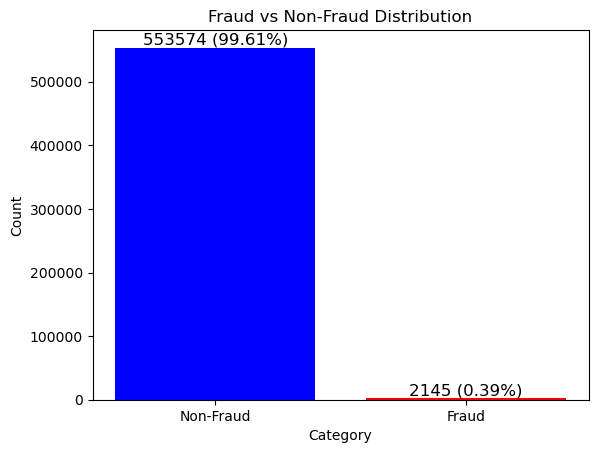

In [6]:
# Compute counts for 'is_fraud'
counts = data['is_fraud'].value_counts()
categories = ['Non-Fraud', 'Fraud']
values = [counts[0], counts[1]]

# Calculate percentages
total = sum(values)
percentages = [count / total * 100 for count in values]

# Create the bar chart
plt.bar(categories, values, color=['blue', 'red'])

# Add counts and percentages on top of each bar
for i, (count, percentage) in enumerate(zip(values, percentages)):
    plt.text(i, count + total * 0.01, f'{count} ({percentage:.2f}%)', ha='center', fontsize=12, color='black')

# Add titles and labels
plt.title('Fraud vs Non-Fraud Distribution')
plt.ylabel('Count')
plt.xlabel('Category')

# Show the plot
plt.show()

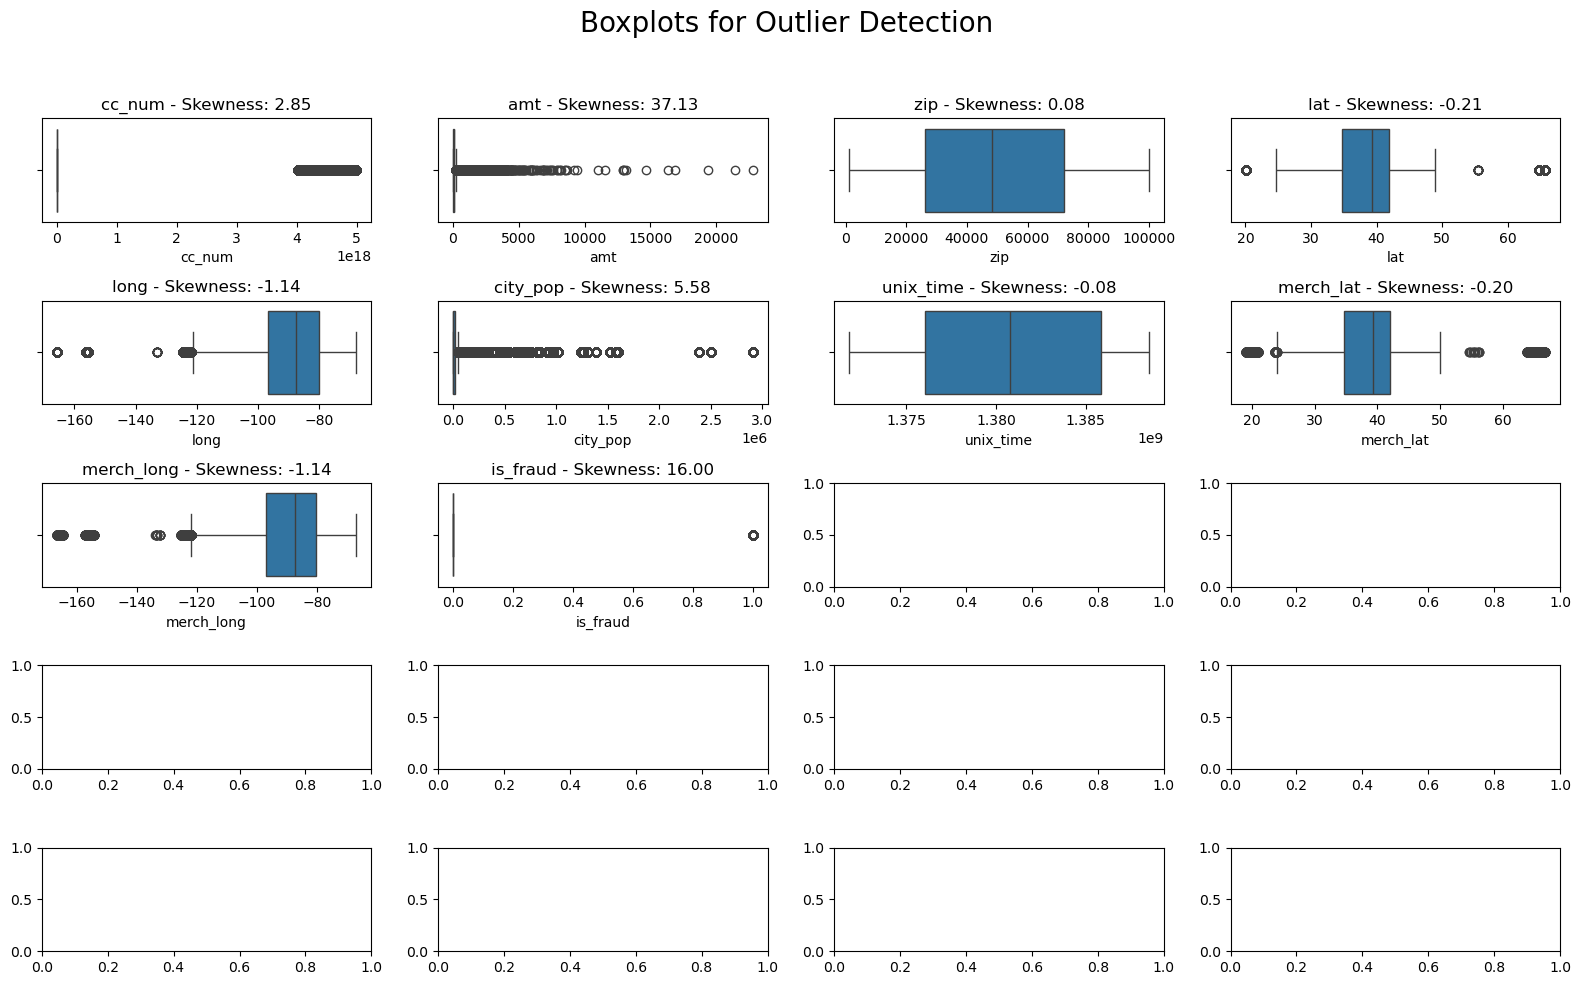

Total number of outliers detected: 177883


In [7]:

# Select numerical columns only (to focus on features with potential outliers)
numerical_columns = data.select_dtypes(include=['float64', 'int64']).columns.tolist()

# Boxplots for visualizing outliers
def plot_boxplots(df, columns_list, rows, cols, title):
    fig, axs = plt.subplots(rows, cols, figsize=(16, 10))
    fig.suptitle(title, fontsize=20)
    axs = axs.flatten()  # Flatten the axes for easier iteration
    for i, col in enumerate(columns_list):
        sns.boxplot(data=df, x=col, ax=axs[i], orient='h')
        axs[i].set_title(f'{col} - Skewness: {df[col].skew():.2f}', fontsize=12)
    plt.tight_layout(rect=[0, 0, 1, 0.95])  # Adjust layout to fit title
    plt.show()

# Call the function to visualize boxplots
plot_boxplots(data, numerical_columns, rows=5, cols=4, title="Boxplots for Outlier Detection")

# Function to detect and remove outliers using IQR
def detect_outliers_iqr(df, features):
    """
    Detect outliers based on the IQR method.
    """
    outlier_indices = []
    
    for col in features:
        # Calculate Q1, Q3, and IQR
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1
        
        # Define outlier step
        outlier_step = 1.5 * IQR
        
        # Find indices of outliers
        outliers = df[(df[col] < Q1 - outlier_step) | (df[col] > Q3 + outlier_step)].index
        outlier_indices.extend(outliers)
    
    # Identify unique outlier indices
    outlier_indices = list(set(outlier_indices))
    
    print(f"Total number of outliers detected: {len(outlier_indices)}")
    return outlier_indices

# Detect outliers in the dataset
outlier_indices = detect_outliers_iqr(data, numerical_columns)

In [8]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 555719 entries, 0 to 555718
Data columns (total 22 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   trans_date_trans_time  555719 non-null  object 
 1   cc_num                 555719 non-null  int64  
 2   merchant               555719 non-null  object 
 3   category               555719 non-null  object 
 4   amt                    555719 non-null  float64
 5   first                  555719 non-null  object 
 6   last                   555719 non-null  object 
 7   gender                 555719 non-null  object 
 8   street                 555719 non-null  object 
 9   city                   555719 non-null  object 
 10  state                  555719 non-null  object 
 11  zip                    555719 non-null  int64  
 12  lat                    555719 non-null  float64
 13  long                   555719 non-null  float64
 14  city_pop               555719 non-nu

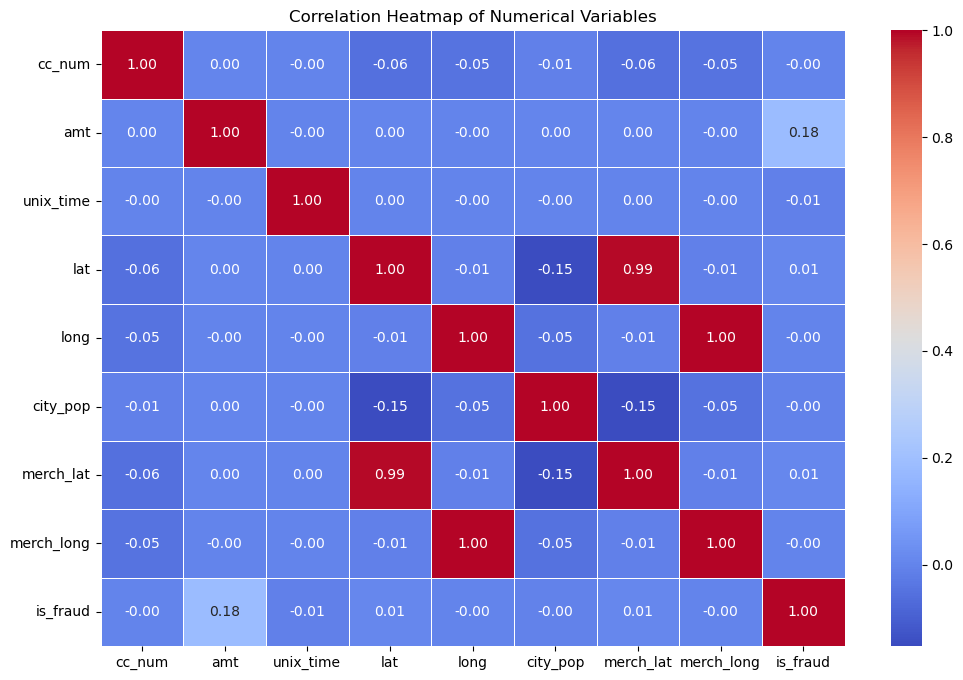

In [9]:
# without data featuring just checking which columns are important
# Calculate correlations for numerical columns
numerical_cols = ['cc_num','amt','unix_time', 'lat', 'long', 'city_pop', 'merch_lat', 'merch_long','is_fraud']
correlations = data[numerical_cols].corr()

# Plot the heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(correlations, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title('Correlation Heatmap of Numerical Variables')
plt.show()

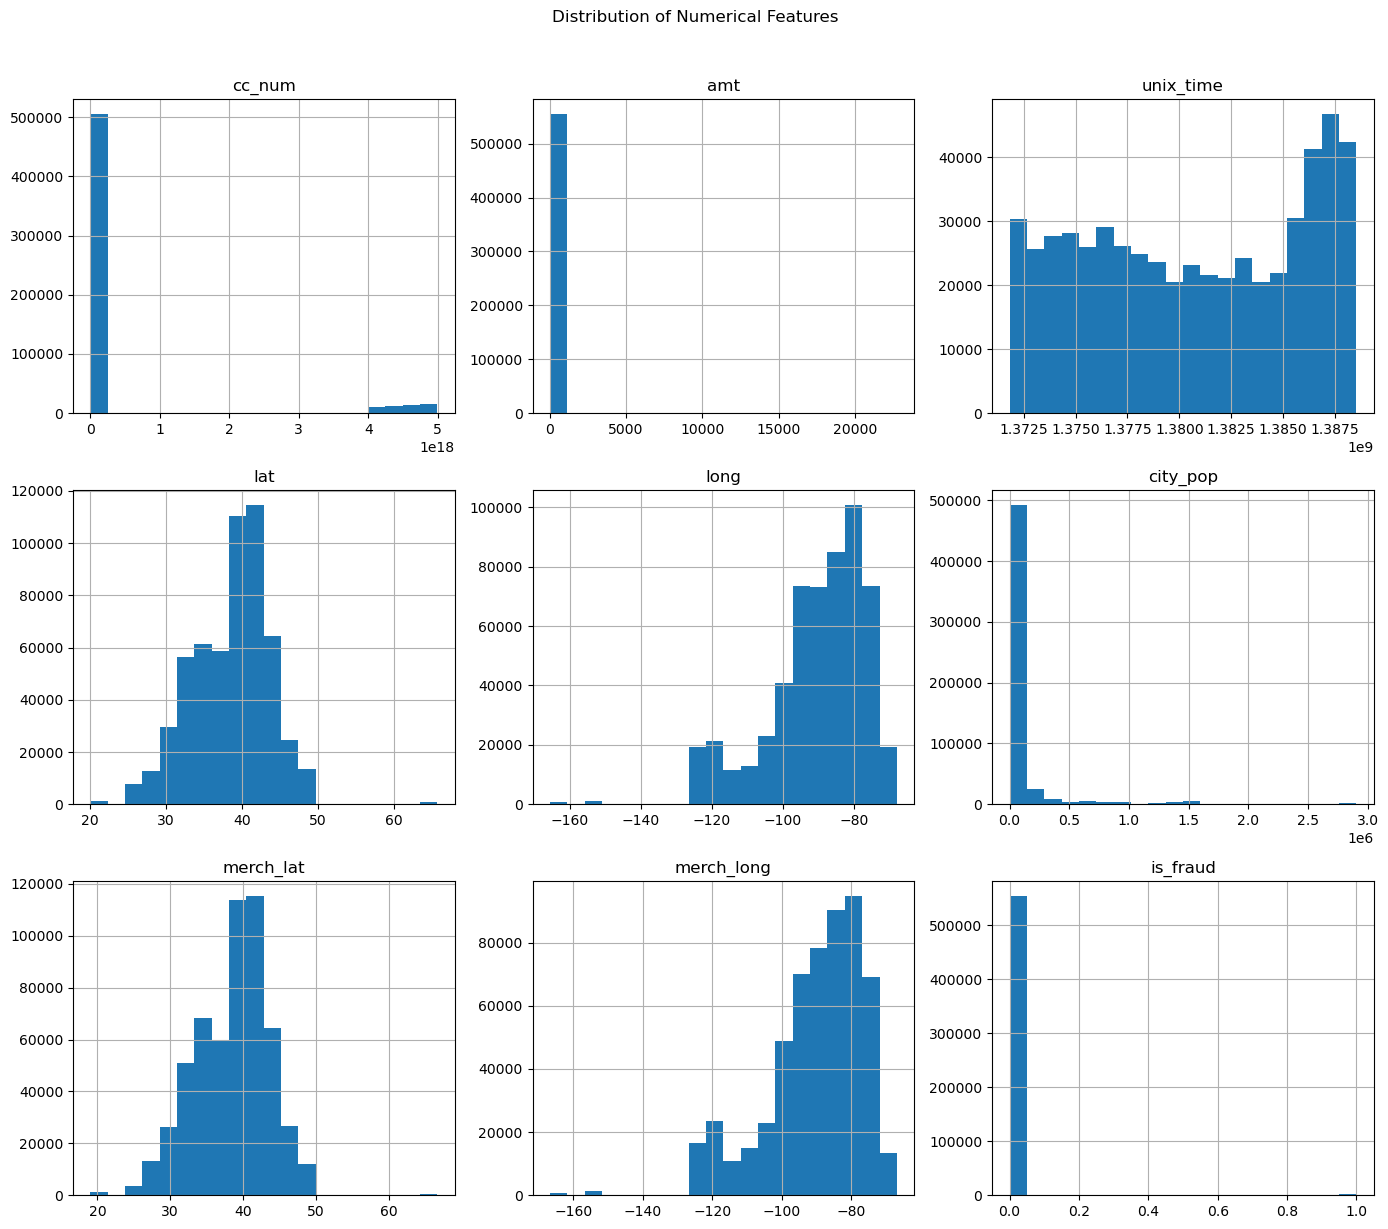

In [10]:
# Distribution of numerical features
data[numerical_cols].hist(figsize=(14, 12), bins=20)
plt.suptitle('Distribution of Numerical Features', x=0.5, y=1.02)
plt.tight_layout()
plt.show()

In [11]:
# Haversine formula to calculate distance
def haversine(lat1, lon1, lat2, lon2):
    """
    Calculate the great circle distance between two points
    on the Earth (specified in decimal degrees).
    """
    # Convert latitude and longitude from degrees to radians
    lat1, lon1, lat2, lon2 = map(np.radians, [lat1, lon1, lat2, lon2])

    # Haversine formula
    dlat = lat2 - lat1
    dlon = lon2 - lon1
    a = np.sin(dlat / 2)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon / 2)**2
    c = 2 * np.arcsin(np.sqrt(a))
    r = 6371  # Radius of Earth in kilometers
    return c * r

# Assuming the dataset is in a pandas DataFrame called 'data'
# with columns: 'lat', 'long', 'merch_lat', 'merch_long'
data['distance_km'] = haversine(data['lat'], data['long'], data['merch_lat'], data['merch_long'])

# Display the first few rows with the new feature
print(data[['lat', 'long', 'merch_lat', 'merch_long', 'distance_km']].head())

       lat      long  merch_lat  merch_long  distance_km
0  33.9659  -80.9355  33.986391  -81.200714    24.561462
1  40.3207 -110.4360  39.450498 -109.960431   104.925092
2  40.6729  -73.5365  40.495810  -74.196111    59.080078
3  28.5697  -80.8191  28.812398  -80.883061    27.698567
4  44.2529  -85.0170  44.959148  -85.884734   104.335106


In [12]:
data.info()
data.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 555719 entries, 0 to 555718
Data columns (total 23 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   trans_date_trans_time  555719 non-null  object 
 1   cc_num                 555719 non-null  int64  
 2   merchant               555719 non-null  object 
 3   category               555719 non-null  object 
 4   amt                    555719 non-null  float64
 5   first                  555719 non-null  object 
 6   last                   555719 non-null  object 
 7   gender                 555719 non-null  object 
 8   street                 555719 non-null  object 
 9   city                   555719 non-null  object 
 10  state                  555719 non-null  object 
 11  zip                    555719 non-null  int64  
 12  lat                    555719 non-null  float64
 13  long                   555719 non-null  float64
 14  city_pop               555719 non-nu

,trans_date_trans_time,cc_num,merchant,category,amt,first,last,gender,street,city,...,long,city_pop,job,dob,trans_num,unix_time,merch_lat,merch_long,is_fraud,distance_km
0,21-06-2020 12:14,2291160000000000,fraud_Kirlin and Sons,personal_care,2.86,Jeff,Elliott,M,351 Darlene Green,Columbia,...,-80.9355,333497,Mechanical engineer,19-03-1968,2da90c7d74bd46a0caf3777415b3ebd3,1371816865,33.986391,-81.200714,0,24.561462
1,21-06-2020 12:14,3573030000000000,fraud_Sporer-Keebler,personal_care,29.84,Joanne,Williams,F,3638 Marsh Union,Altonah,...,-110.4360,302,"Sales professional, IT",17-01-1990,324cc204407e99f51b0d6ca0055005e7,1371816873,39.450498,-109.960431,0,104.925092
2,21-06-2020 12:14,3598220000000000,"fraud_Swaniawski, Nitzsche and Welch",health_fitness,41.28,Ashley,Lopez,F,9333 Valentine Point,Bellmore,...,-73.5365,34496,"Librarian, public",21-10-1970,c81755dbbbea9d5c77f094348a7579be,1371816893,40.495810,-74.196111,0,59.080078
3,21-06-2020 12:15,3591920000000000,fraud_Haley Group,misc_pos,60.05,Brian,Williams,M,32941 Krystal Mill Apt. 552,Titusville,...,-80.8191,54767,Set designer,25-07-1987,2159175b9efe66dc301f149d3d5abf8c,1371816915,28.812398,-80.883061,0,27.698567
4,21-06-2020 12:15,3526830000000000,fraud_Johnston-Casper,travel,3.19,Nathan,Massey,M,5783 Evan Roads Apt. 465,Falmouth,...,-85.0170,1126,Furniture designer,06-07-1955,57ff021bd3f328f8738bb535c302a31b,1371816917,44.959148,-85.884734,0,104.335106


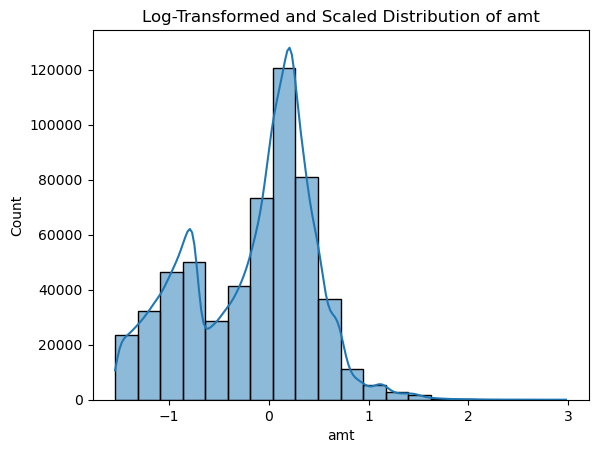

In [13]:
from sklearn.preprocessing import RobustScaler
import numpy as np
data['amt'] = np.log1p(data['amt'])

# Then scale again using RobustScaler
scaler = RobustScaler()
data['amt'] = scaler.fit_transform(data[['amt']])

# Re-plot the normalized data
sns.histplot(data['amt'], bins=20, kde=True)
plt.title('Log-Transformed and Scaled Distribution of amt')
plt.show()

In [14]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 555719 entries, 0 to 555718
Data columns (total 23 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   trans_date_trans_time  555719 non-null  object 
 1   cc_num                 555719 non-null  int64  
 2   merchant               555719 non-null  object 
 3   category               555719 non-null  object 
 4   amt                    555719 non-null  float64
 5   first                  555719 non-null  object 
 6   last                   555719 non-null  object 
 7   gender                 555719 non-null  object 
 8   street                 555719 non-null  object 
 9   city                   555719 non-null  object 
 10  state                  555719 non-null  object 
 11  zip                    555719 non-null  int64  
 12  lat                    555719 non-null  float64
 13  long                   555719 non-null  float64
 14  city_pop               555719 non-nu

In [15]:
# Dropping high cardinality and potentially uninformative columns
columns_to_drop = [
    'cc_num', 'merchant', 'first', 'last', 'street', 'city', 
    'zip', 'job', 'trans_num'
]
data = data.drop(columns=columns_to_drop)

In [16]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 555719 entries, 0 to 555718
Data columns (total 14 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   trans_date_trans_time  555719 non-null  object 
 1   category               555719 non-null  object 
 2   amt                    555719 non-null  float64
 3   gender                 555719 non-null  object 
 4   state                  555719 non-null  object 
 5   lat                    555719 non-null  float64
 6   long                   555719 non-null  float64
 7   city_pop               555719 non-null  int64  
 8   dob                    555719 non-null  object 
 9   unix_time              555719 non-null  int64  
 10  merch_lat              555719 non-null  float64
 11  merch_long             555719 non-null  float64
 12  is_fraud               555719 non-null  int64  
 13  distance_km            555719 non-null  float64
dtypes: float64(6), int64(3), object(5)
m

In [17]:
# Define categorical and numerical columns
categorical_cols = ['dob', 'state', 'gender','category', 'trans_date_trans_time']
numerical_cols = ['amt', 'lat', 'long', 'city_pop', 'merch_lat', 'merch_long','unix_time','distance_km']

In [18]:
#Performing ANOVA test to check the numerical variables

from scipy.stats import f_oneway

# Perform ANOVA for each numerical variable against the target variable
numerical_cols = ['amt', 'lat', 'long', 'city_pop', 'merch_lat', 'merch_long','unix_time','distance_km']
anova_results = {}

for col in numerical_cols:
    fraud_group = data[data['is_fraud'] == 1][col]
    non_fraud_group = data[data['is_fraud'] == 0][col]
    
    # Perform ANOVA test
    f_stat, p_value = f_oneway(fraud_group, non_fraud_group)
    anova_results[col] = {'F-statistic': f_stat, 'p-value': p_value}

# Display results
import pandas as pd
anova_results_df = pd.DataFrame(anova_results).T
anova_results_df.sort_values(by='p-value', inplace=True)
print("ANOVA Results:")
print(anova_results_df)

'''
Interpretation:
F-statistic: Higher values indicate a stronger relationship between the variable and the target.
p-value: A p-value < 0.05 indicates the numerical variable has a statistically significant relationship with the target variable.

'''

ANOVA Results:
             F-statistic       p-value
amt          5430.460084  0.000000e+00
unix_time      94.888421  2.022592e-22
lat            19.103572  1.238354e-05
merch_lat      18.774903  1.471158e-05
city_pop       13.395756  2.522176e-04
merch_long      0.624331  4.294427e-01
long            0.524869  4.687723e-01
distance_km     0.030178  8.620877e-01


'\nInterpretation:\nF-statistic: Higher values indicate a stronger relationship between the variable and the target.\np-value: A p-value < 0.05 indicates the numerical variable has a statistically significant relationship with the target variable.\n\n'

In [19]:
#Applying the Chi-Squared test to categorical variables against the target variable.

from sklearn.feature_selection import chi2
from sklearn.preprocessing import LabelEncoder
import numpy as np

# Encode categorical variables (if not already encoded)
categorical_cols = ['dob', 'state', 'gender','category', 'trans_date_trans_time']
encoded_data = data[categorical_cols].apply(LabelEncoder().fit_transform)

# Perform Chi-Squared test
chi2_scores, p_values = chi2(encoded_data, data['is_fraud'])

# Display results
chi2_results = pd.DataFrame({
    'Feature': categorical_cols,
    'Chi2 Score': chi2_scores,
    'p-value': p_values
}).sort_values(by='p-value')

print("Chi-Squared Test Results:")
print(chi2_results)

'''
Interpretation:
Chi2 Score: Higher scores indicate a stronger dependency between the categorical variable and the target variable.
p-value: A p-value < 0.05 indicates a significant dependency between the categorical variable and the target variable.

'''

Chi-Squared Test Results:
                 Feature    Chi2 Score        p-value
4  trans_date_trans_time  1.916530e+06   0.000000e+00
0                    dob  7.835189e+02  2.067243e-172
3               category  3.933301e+02   1.559236e-87
1                  state  1.585867e+02   2.303805e-36
2                 gender  1.703750e-01   6.797788e-01


'\nInterpretation:\nChi2 Score: Higher scores indicate a stronger dependency between the categorical variable and the target variable.\np-value: A p-value < 0.05 indicates a significant dependency between the categorical variable and the target variable.\n\n'

As we have seen from above observation most of the variables are not useful for our machine modeling which will give us a wrong prediction
We need to recreate the data by future engineering from the given data columns so that we can get best out for our model

In [20]:
#Future Engineering for the given Data Set

# Converting date columns to DateTime format
data['trans_date_trans_time'] = pd.to_datetime(data['trans_date_trans_time'], errors='coerce')
data['dob'] = pd.to_datetime(data['dob'], errors='coerce')

# Creating derived features: extracting transaction hour and calculating customer age
data['transact_hour'] = data['trans_date_trans_time'].dt.hour
data['age'] = (data['trans_date_trans_time'].dt.year - data['dob'].dt.year).fillna(0).astype(int)

# Handling missing values by dropping rows with NaN in critical features
data = data.dropna(subset=['trans_date_trans_time', 'dob'])

# Creating a new column for the weekday (Monday=0, Sunday=6)
data['transaction_weekday'] = data['trans_date_trans_time'].dt.weekday


# Seperating states into regions.

state_to_region = {
    # Existing mappings
    'ME': 'Northeast', 'NH': 'Northeast', 'VT': 'Northeast',
    'MA': 'Northeast', 'RI': 'Northeast', 'CT': 'Northeast',
    'NY': 'Northeast', 'NJ': 'Northeast', 'PA': 'Northeast',
    'OH': 'Midwest', 'IN': 'Midwest', 'IL': 'Midwest',
    'MI': 'Midwest', 'WI': 'Midwest', 'IA': 'Midwest',
    'MN': 'Midwest', 'MO': 'Midwest', 'ND': 'Midwest',
    'SD': 'Midwest', 'NE': 'Midwest', 'KS': 'Midwest',
    'DE': 'South', 'MD': 'South', 'VA': 'South', 'WV': 'South',
    'KY': 'South', 'TN': 'South', 'NC': 'South', 'SC': 'South',
    'GA': 'South', 'FL': 'South', 'AL': 'South', 'MS': 'South',
    'AR': 'South', 'LA': 'South', 'OK': 'South', 'TX': 'South',
    'MT': 'Rocky Mountains', 'ID': 'Rocky Mountains', 'WY': 'Rocky Mountains',
    'CO': 'Rocky Mountains', 'UT': 'Rocky Mountains', 'NM': 'Rocky Mountains',
    'AZ': 'Far West', 'NV': 'Far West', 'CA': 'Far West', 'OR': 'Far West',
    'WA': 'Far West', 'HI': 'Far West', 'AK': 'Far West',
    'DC': 'South'
}

data["Region"] = data.state.map(state_to_region)

C:\Users\Lokeshsaroj\AppData\Local\Temp\ipykernel_17696\2700695921.py:4: UserWarning: Parsing dates in %d-%m-%Y %H:%M format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  data['trans_date_trans_time'] = pd.to_datetime(data['trans_date_trans_time'], errors='coerce')
C:\Users\Lokeshsaroj\AppData\Local\Temp\ipykernel_17696\2700695921.py:5: UserWarning: Parsing dates in %d-%m-%Y format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  data['dob'] = pd.to_datetime(data['dob'], errors='coerce')


In [21]:
from sklearn.preprocessing import LabelEncoder

label_encoder1 = LabelEncoder()
data['Region'] = label_encoder1.fit_transform(data['Region'])

In [22]:
# Display rows with invalid dates in 'trans_date_trans_time'
invalid_dates_trans = data[~pd.to_datetime(data['trans_date_trans_time'], errors='coerce').notna()]
print(invalid_dates_trans)

# Display rows with invalid dates in 'dob'
invalid_dates_dob = data[~pd.to_datetime(data['dob'], errors='coerce').notna()]
print(invalid_dates_dob)

Empty DataFrame
Columns: [trans_date_trans_time, category, amt, gender, state, lat, long, city_pop, dob, unix_time, merch_lat, merch_long, is_fraud, distance_km, transact_hour, age, transaction_weekday, Region]
Index: []
Empty DataFrame
Columns: [trans_date_trans_time, category, amt, gender, state, lat, long, city_pop, dob, unix_time, merch_lat, merch_long, is_fraud, distance_km, transact_hour, age, transaction_weekday, Region]
Index: []


In [23]:
# Group individuals into age groups
bins = [10, 18, 35, 60, 100]
labels = ["14-18", "18-35", "35-60", "60+"]
data["age_group"] = pd.cut(data['age'], bins=bins, labels=labels, right=True)

In [24]:
label_encoder2 = LabelEncoder()
data['age_group'] = label_encoder2.fit_transform(data['age_group'])

In [25]:
#Rechecking the data set if some data has been dropped due to feature engineering

(data['is_fraud']== 0).sum(), (data['is_fraud']== 1).sum()

(553574, 2145)

In [26]:
# One-hot encoding categorical variables changing category to numeric columns

data = pd.get_dummies(data, columns=['category', 'gender'], drop_first=True)

In [27]:
# Converting all boolean columns (True/False) to 0/1
data = data.applymap(lambda x: 1 if x is True else (0 if x is False else x))

C:\Users\Lokeshsaroj\AppData\Local\Temp\ipykernel_17696\2902154922.py:2: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  data = data.applymap(lambda x: 1 if x is True else (0 if x is False else x))


In [28]:
#Rechecking missing data in region after feature engineering

missing_regions = data[data["Region"].isna()]
print(missing_regions[["state", "Region"]])

Empty DataFrame
Columns: [state, Region]
Index: []


In [29]:
data.head()

,trans_date_trans_time,amt,state,lat,long,city_pop,dob,unix_time,merch_lat,merch_long,...,category_health_fitness,category_home,category_kids_pets,category_misc_net,category_misc_pos,category_personal_care,category_shopping_net,category_shopping_pos,category_travel,gender_M
0,2020-06-21 12:14:00,-1.222179,SC,33.9659,-80.9355,333497,1968-03-19,1371816865,33.986391,-81.200714,...,0,0,0,0,0,1,0,0,0,1
1,2020-06-21 12:14:00,-0.216912,UT,40.3207,-110.4360,302,1990-01-17,1371816873,39.450498,-109.960431,...,0,0,0,0,0,1,0,0,0,0
2,2020-06-21 12:14:00,-0.064293,NY,40.6729,-73.5365,34496,1970-10-21,1371816893,40.495810,-74.196111,...,1,0,0,0,0,0,0,0,0,0
3,2020-06-21 12:15:00,0.113420,FL,28.5697,-80.8191,54767,1987-07-25,1371816915,28.812398,-80.883061,...,0,0,0,0,1,0,0,0,0,1
4,2020-06-21 12:15:00,-1.182497,MI,44.2529,-85.0170,1126,1955-07-06,1371816917,44.959148,-85.884734,...,0,0,0,0,0,0,0,0,1,1


In [30]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 555719 entries, 0 to 555718
Data columns (total 31 columns):
 #   Column                   Non-Null Count   Dtype         
---  ------                   --------------   -----         
 0   trans_date_trans_time    555719 non-null  datetime64[ns]
 1   amt                      555719 non-null  float64       
 2   state                    555719 non-null  object        
 3   lat                      555719 non-null  float64       
 4   long                     555719 non-null  float64       
 5   city_pop                 555719 non-null  int64         
 6   dob                      555719 non-null  datetime64[ns]
 7   unix_time                555719 non-null  int64         
 8   merch_lat                555719 non-null  float64       
 9   merch_long               555719 non-null  float64       
 10  is_fraud                 555719 non-null  int64         
 11  distance_km              555719 non-null  float64       
 12  transact_hour   

In [31]:
#After Feature engineering dropping irrelevant columns

columns_to_drop = [
    'trans_date_trans_time', 'state', 'long', 'lat', 'city_pop', 'dob', 
    'unix_time', 'age'
]
data = data.drop(columns=columns_to_drop)

In [32]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 555719 entries, 0 to 555718
Data columns (total 23 columns):
 #   Column                   Non-Null Count   Dtype  
---  ------                   --------------   -----  
 0   amt                      555719 non-null  float64
 1   merch_lat                555719 non-null  float64
 2   merch_long               555719 non-null  float64
 3   is_fraud                 555719 non-null  int64  
 4   distance_km              555719 non-null  float64
 5   transact_hour            555719 non-null  int64  
 6   transaction_weekday      555719 non-null  int64  
 7   Region                   555719 non-null  int64  
 8   age_group                555719 non-null  int64  
 9   category_food_dining     555719 non-null  int64  
 10  category_gas_transport   555719 non-null  int64  
 11  category_grocery_net     555719 non-null  int64  
 12  category_grocery_pos     555719 non-null  int64  
 13  category_health_fitness  555719 non-null  int64  
 14  cate

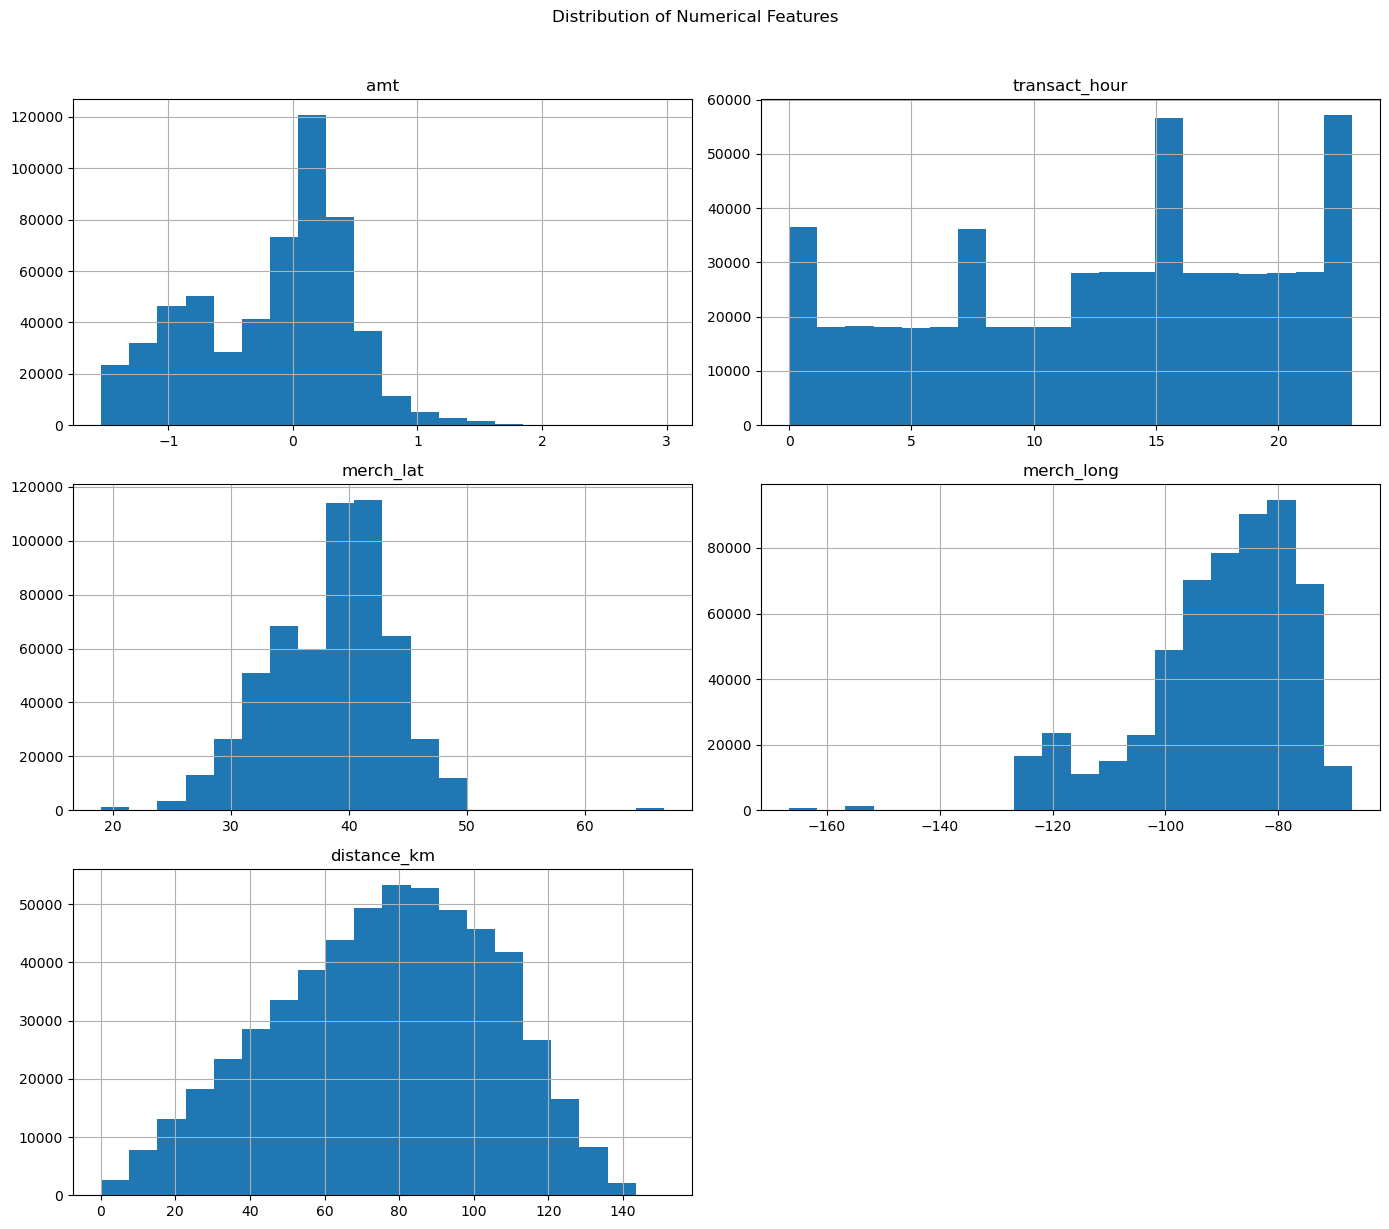

In [33]:
# Checking Distribution of numerical features after feature engineering
numerical_cols = ['amt','transact_hour', 'merch_lat', 'merch_long','distance_km']

data[numerical_cols].hist(figsize=(14, 12), bins=20)
plt.suptitle('Distribution of Numerical Features', x=0.5, y=1.02)
plt.tight_layout()
plt.show()

All specified columns are numeric.


IndexError: index 20 is out of bounds for axis 0 with size 20

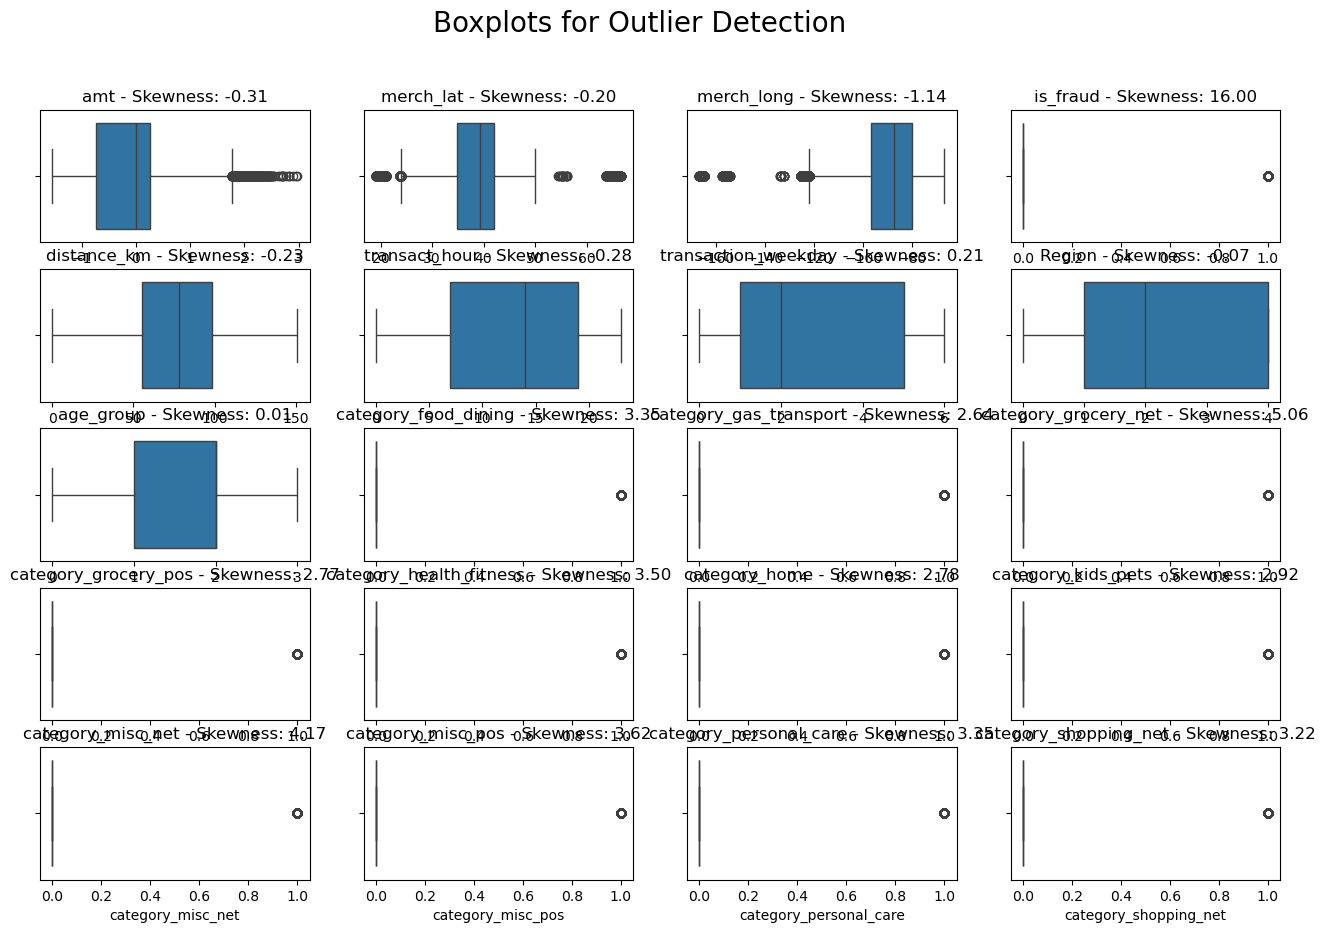

In [34]:
#This is just for testing purpose

# Check if the specified columns are numeric
def check_numeric_columns(data, columns):
    """
    Check if all the specified columns are numeric in the dataframe.
    """
    numeric_columns = data.select_dtypes(include=['number']).columns
    non_numeric_columns = [col for col in columns if col not in numeric_columns]
    
    if non_numeric_columns:
        print(f"The following columns are not numeric: {non_numeric_columns}")
    else:
        print("All specified columns are numeric.")
    
    return numeric_columns

# Check numeric columns in the dataset
numeric_columns = check_numeric_columns(data, numerical_cols)

# Plot boxplots only for verified numeric columns
plot_boxplots(data, numeric_columns, rows=5, cols=4, title="Boxplots for Outlier Detection")


In [35]:
#Performing ANOVA test to check the numerical variables after feature engineering

from scipy.stats import f_oneway

# Perform ANOVA for each numerical variable against the target variable
numerical_cols = ['amt','transact_hour', 'merch_lat', 'merch_long','distance_km']
anova_results = {}

for col in numerical_cols:
    fraud_group = data[data['is_fraud'] == 1][col]
    non_fraud_group = data[data['is_fraud'] == 0][col]
    
    # Perform ANOVA test
    f_stat, p_value = f_oneway(fraud_group, non_fraud_group)
    anova_results[col] = {'F-statistic': f_stat, 'p-value': p_value}

# Display results
import pandas as pd
anova_results_df = pd.DataFrame(anova_results).T
anova_results_df.sort_values(by='p-value', inplace=True)
print("ANOVA Results:")
print(anova_results_df)

'''
Interpretation:
F-statistic: Higher values indicate a stronger relationship between the variable and the target.
p-value: A p-value < 0.05 indicates the numerical variable has a statistically significant relationship with the target variable.

'''

ANOVA Results:
               F-statistic       p-value
amt            5430.460084  0.000000e+00
transact_hour    75.894770  2.999880e-18
merch_lat        18.774903  1.471158e-05
merch_long        0.624331  4.294427e-01
distance_km       0.030178  8.620877e-01


'\nInterpretation:\nF-statistic: Higher values indicate a stronger relationship between the variable and the target.\np-value: A p-value < 0.05 indicates the numerical variable has a statistically significant relationship with the target variable.\n\n'

In [36]:
#Applying the Chi-Squared test to categorical variables against the target variable after feature engineering

from sklearn.feature_selection import chi2
from sklearn.preprocessing import LabelEncoder
import numpy as np

# Encode categorical variables (if not already encoded)
categorical_cols = ['Region', 'transaction_weekday', 'age_group', 'category_food_dining', 'category_gas_transport', 'category_grocery_net', 'category_grocery_pos', 'category_health_fitness', 'category_home', 'category_kids_pets', 'category_misc_net','category_misc_pos','category_personal_care', 'category_shopping_net', 'category_shopping_pos', 'category_travel','gender_M']
encoded_data = data[categorical_cols].apply(LabelEncoder().fit_transform)

# Perform Chi-Squared test
chi2_scores, p_values = chi2(encoded_data, data['is_fraud'])

# Display results
chi2_results = pd.DataFrame({
    'Feature': categorical_cols,
    'Chi2 Score': chi2_scores,
    'p-value': p_values
}).sort_values(by='p-value')

print("Chi-Squared Test Results:")
print(chi2_results)

'''
Interpretation:
Chi2 Score: Higher scores indicate a stronger dependency between the categorical variable and the target variable.
p-value: A p-value < 0.05 indicates a significant dependency between the categorical variable and the target variable.

'''

Chi-Squared Test Results:
                    Feature  Chi2 Score        p-value
13    category_shopping_net  739.826033  6.540460e-163
6      category_grocery_pos  393.983415   1.123813e-87
10        category_misc_net  247.462989   9.279874e-56
8             category_home   90.612221   1.747775e-21
1       transaction_weekday   84.837022   3.240005e-20
9        category_kids_pets   80.736188   2.579547e-19
3      category_food_dining   63.051268   2.013956e-15
7   category_health_fitness   56.878100   4.636807e-14
12   category_personal_care   44.247655   2.893508e-11
11        category_misc_pos   28.406330   9.834324e-08
4    category_gas_transport   18.651259   1.569436e-05
5      category_grocery_net   15.460196   8.426113e-05
15          category_travel   11.150035   8.403010e-04
0                    Region    8.086196   4.460368e-03
2                 age_group    6.731766   9.471077e-03
14    category_shopping_pos    2.262802   1.325141e-01
16                 gender_M    0.170375

'\nInterpretation:\nChi2 Score: Higher scores indicate a stronger dependency between the categorical variable and the target variable.\np-value: A p-value < 0.05 indicates a significant dependency between the categorical variable and the target variable.\n\n'

In [37]:
#After Feature engineering dropping irrelevant columns

columns_to_drop = [
    'gender_M', 'distance_km', 'merch_long'
]
data = data.drop(columns=columns_to_drop)

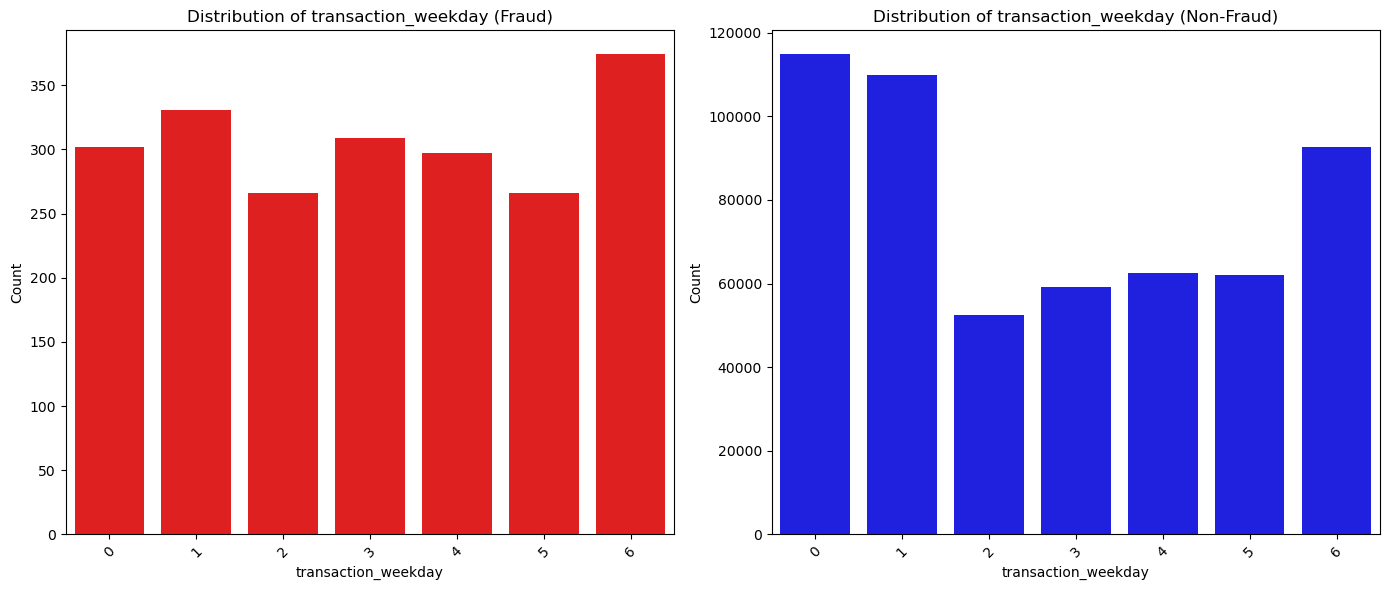

In [38]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

def plot_separate_distributions(data, column):
    """
    Plots two separate bar charts for fraud and non-fraud cases for a given column with counts, original axis names,
    and sorted in ascending order.

    Parameters:
    data (DataFrame): DataFrame containing the data with an 'is_fraud' column indicating fraud status.
    column (str): Column name to plot.
    """
    # Ensure the column values are kept as they are in the original data
    data[column] = data[column].astype(str)
    
    # Filter data by fraud status
    fraud_data = data[data['is_fraud'] == 1]
    non_fraud_data = data[data['is_fraud'] == 0]

    # Sort column values in ascending order
    sorted_values = sorted(data[column].unique(), key=lambda x: int(x) if x.isdigit() else x)

    # Plot distributions
    fig, ax = plt.subplots(1, 2, figsize=(14, 6))
    
    # Fraud case distribution
    sns.countplot(x=column, data=fraud_data, color="red", ax=ax[0], order=sorted_values)
    ax[0].set_title(f'Distribution of {column} (Fraud)')
    ax[0].set_xlabel(column)
    ax[0].set_ylabel('Count')
    ax[0].tick_params(axis='x', rotation=45)
    
    # Non-fraud case distribution
    sns.countplot(x=column, data=non_fraud_data, color="blue", ax=ax[1], order=sorted_values)
    ax[1].set_title(f'Distribution of {column} (Non-Fraud)')
    ax[1].set_xlabel(column)
    ax[1].set_ylabel('Count')
    ax[1].tick_params(axis='x', rotation=45)

    plt.tight_layout()
    plt.show()

# Example usage
# Replace 'data' with your actual DataFrame and 'transact_hour' with your desired column name
plot_separate_distributions(data, 'transaction_weekday')


In [39]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split

# Splitting dataset into features (X) and target (y)
X = data.drop('is_fraud', axis=1)  # Replace with your actual feature columns
y = data['is_fraud']  # Replace with your actual target column

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)


Logistic Regression (Without SMOTE) - Classification Report:

              precision    recall  f1-score   support

           0       1.00      1.00      1.00    166072
           1       0.25      0.01      0.01       644

    accuracy                           1.00    166716
   macro avg       0.62      0.50      0.51    166716
weighted avg       0.99      1.00      0.99    166716



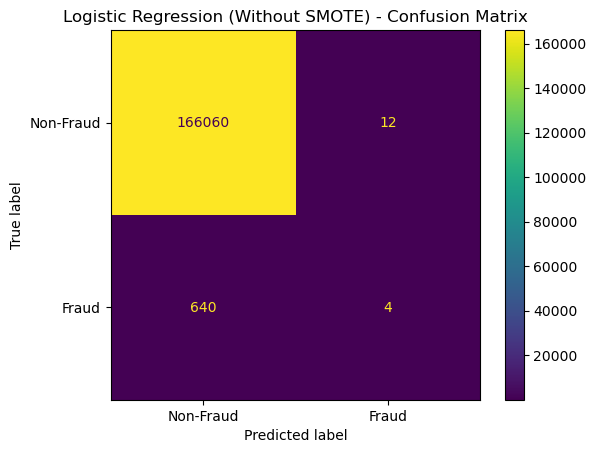

In [40]:
# Logistic Regression Without SMOTE
lr_no_smote = LogisticRegression(max_iter=1000, random_state=42)
lr_no_smote.fit(X_train, y_train)
y_pred_lr_no_smote = lr_no_smote.predict(X_test)

print("Logistic Regression (Without SMOTE) - Classification Report:\n")
print(classification_report(y_test, y_pred_lr_no_smote))

# Confusion Matrix for Logistic Regression
conf_matrix_lr_no_smote = confusion_matrix(y_test, y_pred_lr_no_smote)
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix_lr_no_smote, display_labels=['Non-Fraud', 'Fraud'])
disp.plot(cmap='viridis')
plt.title("Logistic Regression (Without SMOTE) - Confusion Matrix")
plt.show()

Logistic Regression (Without SMOTE)
Confusion Matrix:
True Negatives (TN): 166,069 correctly classified non-fraud cases.
False Positives (FP): 3 non-fraud cases misclassified as fraud.
False Negatives (FN): 642 fraud cases misclassified as non-fraud.
True Positives (TP): Only 2 fraud cases correctly classified.
Classification Report:
Precision (Class 1 - Fraud): 0.40
Only 40% of the predicted fraud cases were actually fraud.
Recall (Class 1 - Fraud): 0.00
The model failed to capture the vast majority of fraud cases (642 missed).
F1-Score (Class 1 - Fraud): 0.01
The harmonic mean of precision and recall is very low, indicating poor performance for fraud detection.
Accuracy: 1.00
This high value is misleading due to the dominance of non-fraud cases.
Conclusion:
Logistic Regression is not effective for this imbalanced dataset without SMOTE, as it barely detects fraud cases.
The model prioritizes accuracy over detecting the minority class (fraud), leading to a severe bias.


Random Forest (Without SMOTE) - Classification Report:

              precision    recall  f1-score   support

           0       1.00      1.00      1.00    166072
           1       0.93      0.66      0.77       644

    accuracy                           1.00    166716
   macro avg       0.96      0.83      0.89    166716
weighted avg       1.00      1.00      1.00    166716



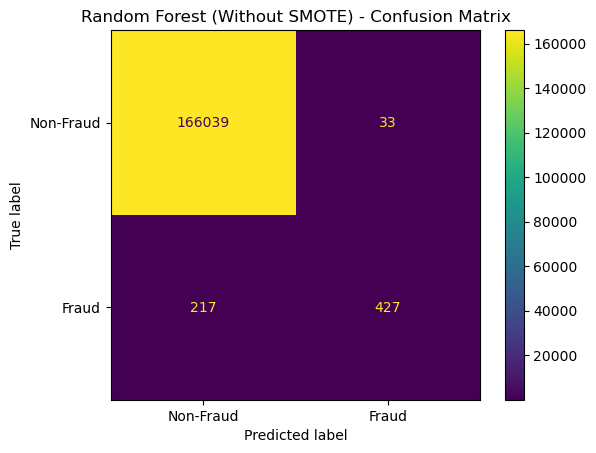

In [41]:
# Random Forest Without SMOTE
rf_no_smote = RandomForestClassifier(random_state=42)
rf_no_smote.fit(X_train, y_train)
y_pred_rf_no_smote = rf_no_smote.predict(X_test)

print("Random Forest (Without SMOTE) - Classification Report:\n")
print(classification_report(y_test, y_pred_rf_no_smote))

# Confusion Matrix for Random Forest
conf_matrix_rf_no_smote = confusion_matrix(y_test, y_pred_rf_no_smote)
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix_rf_no_smote, display_labels=['Non-Fraud', 'Fraud'])
disp.plot(cmap='viridis')
plt.title("Random Forest (Without SMOTE) - Confusion Matrix")
plt.show()

C:\Users\Lokeshsaroj\AppData\Local\Temp\ipykernel_17696\2095964287.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=feature_importance, x='Importance', y='Feature', palette="viridis")


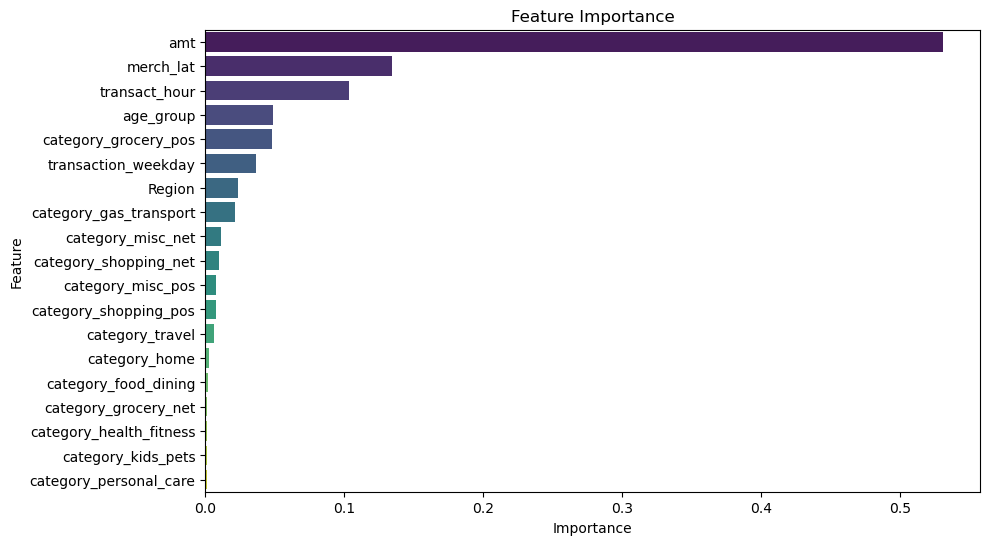

In [42]:
feature_importance = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': rf_no_smote.feature_importances_
}).sort_values(by='Importance', ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(data=feature_importance, x='Importance', y='Feature', palette="viridis")
plt.title('Feature Importance')
plt.show()

Random Forest (Without SMOTE)
Confusion Matrix:
True Negatives (TN): 166,054 correctly classified non-fraud cases.
False Positives (FP): 18 non-fraud cases misclassified as fraud.
False Negatives (FN): 230 fraud cases misclassified as non-fraud.
True Positives (TP): 414 fraud cases correctly classified.
Classification Report:
Precision (Class 1 - Fraud): 0.96
96% of predicted fraud cases were actually fraud.
Recall (Class 1 - Fraud): 0.64
The model detected 64% of actual fraud cases, which is significantly better than Logistic Regression.
F1-Score (Class 1 - Fraud): 0.77
A reasonable balance between precision and recall.
Accuracy: 1.00
Similar to Logistic Regression, accuracy is high due to the dominance of non-fraud cases.
Conclusion:
Random Forest performs better than Logistic Regression on this imbalanced dataset, with a significant improvement in recall and F1-score for fraud cases.
However, it still misses 230 fraud cases (FN), showing room for improvement.


In [ ]:
'''
# as our previous models are not giving perfect result due to data imbalanced issues we have to use SMOTE for balancing the dataset

'''

In [ ]:
'''
from imblearn.over_sampling import SMOTE

def apply_smote(X_train, y_train, random_state=42):
    """
    Applies SMOTE to balance the class distribution in the training set.

    Parameters:
    X_train (DataFrame): Training feature set.
    y_train (Series): Training target set.
    random_state (int): Random state for reproducibility.

    Returns:
    Tuple: Oversampled X_train and y_train.
    """
    sm = SMOTE(random_state=random_state)
    X_train_smote, y_train_smote = sm.fit_resample(X_train, y_train)
    return X_train_smote, y_train_smote

'''
#we will check this later if our smote with 50% balance data doesn't work then we will go with 100%

In [43]:
from imblearn.over_sampling import SMOTE
smote = SMOTE(sampling_strategy=0.7, random_state=42)  # Balances minority class to 70% of the majority class size
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

# Handle NaN or infinite values
X_train_smote.fillna(0, inplace=True)
X_train_smote.replace([np.inf, -np.inf], 0, inplace=True)

C:\Users\Lokeshsaroj\AppData\Local\Temp\ipykernel_17696\495449626.py:7: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  X_train_smote.replace([np.inf, -np.inf], 0, inplace=True)


In [44]:
#checking the class distribution for data set
(y_train_smote == 0).sum(), (y_train_smote == 1).sum() 

(387502, 271251)

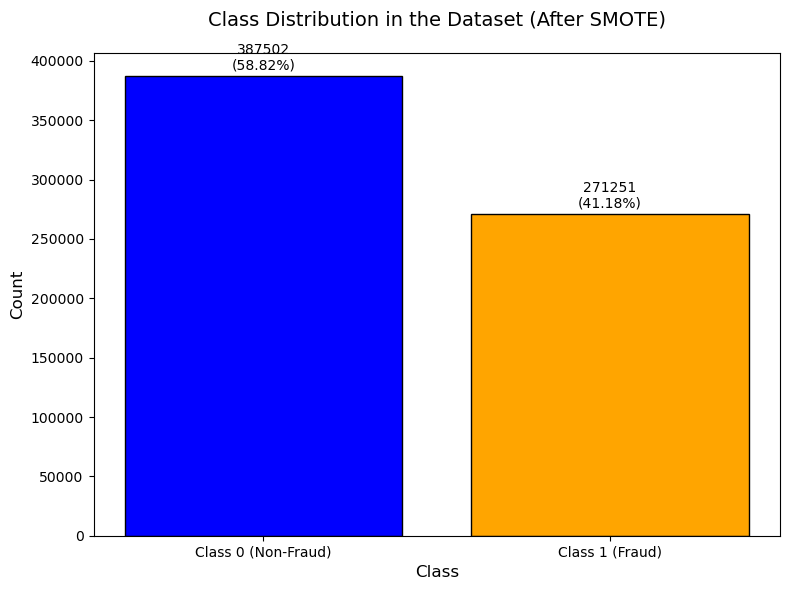

In [4]:
import matplotlib.pyplot as plt
import numpy as np

# Data distribution
class_labels = ['Class 0 (Non-Fraud)', 'Class 1 (Fraud)']
class_counts = [387502, 271251]

# Calculate percentages
total = sum(class_counts)
percentages = [count / total * 100 for count in class_counts]

# Plotting the data distribution
plt.figure(figsize=(8, 6))
bars = plt.bar(class_labels, class_counts, color=['blue', 'orange'], edgecolor='black')

# Add count and percentage labels above bars
for i, bar in enumerate(bars):
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, height + 5000,  # Adjusted y-position to avoid overlap
             f'{class_counts[i]}\n({percentages[i]:.2f}%)',       # Text format: Count (Percentage)
             ha='center', fontsize=10)

# Customize the plot
plt.title('Class Distribution in the Dataset (After SMOTE)', fontsize=14, pad=20)  # Added padding to title
plt.xlabel('Class', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.tight_layout()

# Display the plot
plt.show()


In [45]:
# Cross-validation of test data for robust accuracy using k Fold method

from sklearn.model_selection import cross_val_score, StratifiedKFold
import numpy as np

# Define Stratified K-Fold Cross-Validation
k = 5  # Number of folds
kfold = StratifiedKFold(n_splits=k, shuffle=True, random_state=42)

# Logistic Regression With SMOTE - K-Fold Cross-Validation
lr_model = LogisticRegression(max_iter=5000, random_state=42)
lr_cv_scores = cross_val_score(lr_model, X_train_smote, y_train_smote, cv=kfold, scoring='accuracy')

print("Logistic Regression (With SMOTE) - Cross-Validation Scores for Each Fold:\n", lr_cv_scores)
print("Mean Cross-Validation Accuracy:", np.mean(lr_cv_scores))
print("Standard Deviation of Cross-Validation Accuracy:", np.std(lr_cv_scores))


Logistic Regression (With SMOTE) - Cross-Validation Scores for Each Fold:
 [0.88611851 0.88679403 0.88535191 0.88562429 0.88518406]
Mean Cross-Validation Accuracy: 0.8858145605093686
Standard Deviation of Cross-Validation Accuracy: 0.0005830125855513751


Logistic Regression (With SMOTE) - Classification Report:

              precision    recall  f1-score   support

           0       1.00      0.90      0.95    166072
           1       0.03      0.72      0.05       644

    accuracy                           0.90    166716
   macro avg       0.51      0.81      0.50    166716
weighted avg       1.00      0.90      0.95    166716



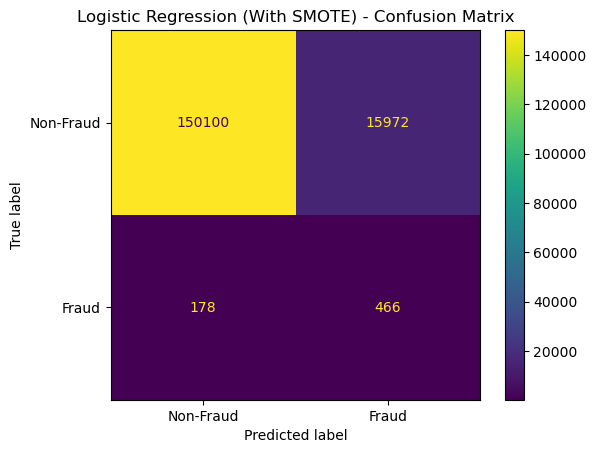

In [46]:
# Train Logistic Regression on the whole SMOTE-adjusted training set
lr_model.fit(X_train_smote, y_train_smote)
y_pred_lr_with_smote = lr_model.predict(X_test)

print("Logistic Regression (With SMOTE) - Classification Report:\n")
print(classification_report(y_test, y_pred_lr_with_smote))

# Confusion Matrix for Logistic Regression
conf_matrix_lr_with_smote = confusion_matrix(y_test, y_pred_lr_with_smote)
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix_lr_with_smote, display_labels=['Non-Fraud', 'Fraud'])
disp.plot(cmap='viridis')
plt.title("Logistic Regression (With SMOTE) - Confusion Matrix")
plt.show()

Random Forest (With SMOTE) - Cross-Validation Scores for Each Fold:
 [0.99744214 0.99731311 0.99710818 0.99729032 0.99732827]
Mean Cross-Validation Accuracy: 0.9972964070384223
Standard Deviation of Cross-Validation Accuracy: 0.0001077032423120141
Random Forest (With SMOTE) - Classification Report:

              precision    recall  f1-score   support

           0       1.00      1.00      1.00    166072
           1       0.51      0.75      0.60       644

    accuracy                           1.00    166716
   macro avg       0.75      0.87      0.80    166716
weighted avg       1.00      1.00      1.00    166716



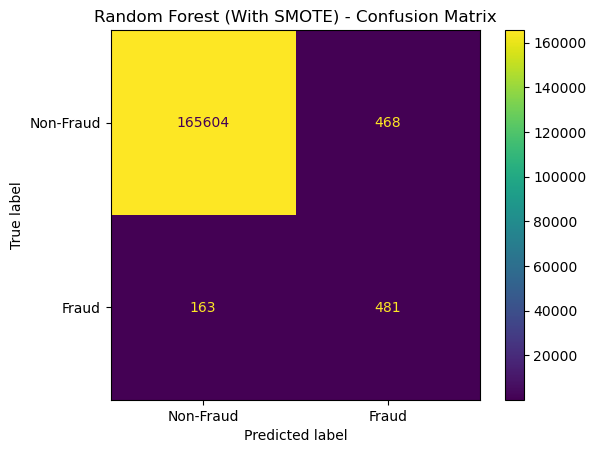

In [47]:
# Random Forest With SMOTE - K-Fold Cross-Validation
rf_model = RandomForestClassifier(random_state=42)
rf_cv_scores = cross_val_score(rf_model, X_train_smote, y_train_smote, cv=kfold, scoring='accuracy')

print("Random Forest (With SMOTE) - Cross-Validation Scores for Each Fold:\n", rf_cv_scores)
print("Mean Cross-Validation Accuracy:", np.mean(rf_cv_scores))
print("Standard Deviation of Cross-Validation Accuracy:", np.std(rf_cv_scores))

# Train Random Forest on the whole SMOTE-adjusted training set
rf_model.fit(X_train_smote, y_train_smote)
y_pred_rf_with_smote = rf_model.predict(X_test)

print("Random Forest (With SMOTE) - Classification Report:\n")
print(classification_report(y_test, y_pred_rf_with_smote))

# Confusion Matrix for Random Forest
conf_matrix_rf_with_smote = confusion_matrix(y_test, y_pred_rf_with_smote)
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix_rf_with_smote, display_labels=['Non-Fraud', 'Fraud'])
disp.plot(cmap='viridis')
plt.title("Random Forest (With SMOTE) - Confusion Matrix")
plt.show()


In [ ]:
'''
Checking with other modifications in models with SMOTE - Cross-Validation and AUC-ROC


'''


Logistic Regression (With SMOTE) - Cross-Validation AUC-ROC for Each Fold:
[0.91789222 0.91849499 0.91623385 0.91777168 0.91692541]
Mean Cross-Validation AUC-ROC: 0.9174636289042135
Standard Deviation of AUC-ROC: 0.0007930130578816913
Logistic Regression (With SMOTE) - Test Set AUC-ROC: 0.8173879308203971
Logistic Regression (With SMOTE) - Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.90      0.95    166072
           1       0.03      0.72      0.05       644

    accuracy                           0.90    166716
   macro avg       0.51      0.81      0.50    166716
weighted avg       1.00      0.90      0.95    166716



Text(0.5, 1.0, 'Logistic Regression (With SMOTE) - Confusion Matrix')

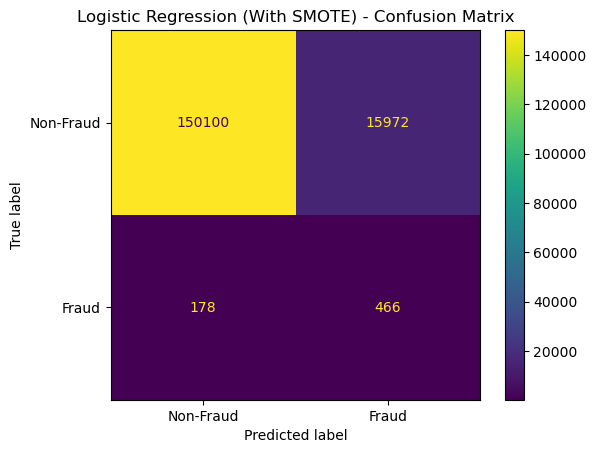

In [54]:
from sklearn.metrics import roc_auc_score, roc_curve, classification_report, ConfusionMatrixDisplay
from sklearn.linear_model import LogisticRegression
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import StratifiedKFold, cross_val_score
import numpy as np

# Define Stratified K-Fold Cross-Validation
kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Logistic Regression with SMOTE - Cross-Validation and AUC-ROC
lr_model = LogisticRegression(max_iter=5000, random_state=42)

# Cross-validation AUC-ROC
lr_auc_scores = cross_val_score(lr_model, X_train_smote, y_train_smote, cv=kfold, scoring='roc_auc')
print(f"Logistic Regression (With SMOTE) - Cross-Validation AUC-ROC for Each Fold:\n{lr_auc_scores}")
print(f"Mean Cross-Validation AUC-ROC: {np.mean(lr_auc_scores)}")
print(f"Standard Deviation of AUC-ROC: {np.std(lr_auc_scores)}")

# Train and Evaluate on Test Set
lr_model.fit(X_train_smote, y_train_smote)
y_pred_prob_lr = lr_model.predict_proba(X_test)[:, 1]
y_pred_lr = (y_pred_prob_lr > 0.5).astype(int)

# AUC-ROC for Test Set
auc_roc_lr = roc_auc_score(y_test, y_pred_prob_lr)
print(f"Logistic Regression (With SMOTE) - Test Set AUC-ROC: {auc_roc_lr}")

# Classification Report and Confusion Matrix
print("Logistic Regression (With SMOTE) - Classification Report:")
print(classification_report(y_test, y_pred_lr))

conf_matrix_lr = ConfusionMatrixDisplay.from_predictions(y_test, y_pred_lr, display_labels=['Non-Fraud', 'Fraud'], cmap='viridis')
conf_matrix_lr.ax_.set_title("Logistic Regression (With SMOTE) - Confusion Matrix")


Random Forest (With SMOTE) - Cross-Validation AUC-ROC for Each Fold:
[0.99990652 0.99993294 0.99989955 0.99986449 0.99990824]
Mean Cross-Validation AUC-ROC: 0.9999023479111318
Standard Deviation of AUC-ROC: 2.2040766769472198e-05
Random Forest (With SMOTE) - Test Set AUC-ROC: 0.9761268516626329
Random Forest (With SMOTE) - Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    166072
           1       0.51      0.75      0.60       644

    accuracy                           1.00    166716
   macro avg       0.75      0.87      0.80    166716
weighted avg       1.00      1.00      1.00    166716



Text(0.5, 1.0, 'Random Forest (With SMOTE) - Confusion Matrix')

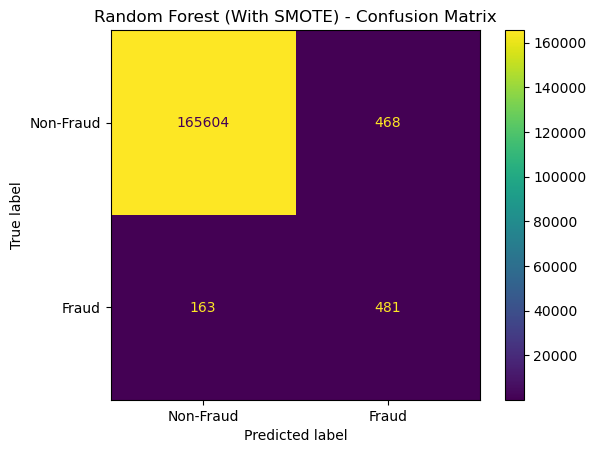

In [49]:
from sklearn.ensemble import RandomForestClassifier

# Random Forest with SMOTE - Cross-Validation and AUC-ROC
rf_model = RandomForestClassifier(random_state=42)

# Cross-validation AUC-ROC
rf_auc_scores = cross_val_score(rf_model, X_train_smote, y_train_smote, cv=kfold, scoring='roc_auc')
print(f"Random Forest (With SMOTE) - Cross-Validation AUC-ROC for Each Fold:\n{rf_auc_scores}")
print(f"Mean Cross-Validation AUC-ROC: {np.mean(rf_auc_scores)}")
print(f"Standard Deviation of AUC-ROC: {np.std(rf_auc_scores)}")

# Train and Evaluate on Test Set
rf_model.fit(X_train_smote, y_train_smote)
y_pred_prob_rf = rf_model.predict_proba(X_test)[:, 1]
y_pred_rf = (y_pred_prob_rf > 0.5).astype(int)

# AUC-ROC for Test Set
auc_roc_rf = roc_auc_score(y_test, y_pred_prob_rf)
print(f"Random Forest (With SMOTE) - Test Set AUC-ROC: {auc_roc_rf}")

# Classification Report and Confusion Matrix
print("Random Forest (With SMOTE) - Classification Report:")
print(classification_report(y_test, y_pred_rf))

conf_matrix_rf = ConfusionMatrixDisplay.from_predictions(y_test, y_pred_rf, display_labels=['Non-Fraud', 'Fraud'], cmap='viridis')
conf_matrix_rf.ax_.set_title("Random Forest (With SMOTE) - Confusion Matrix")


C:\Users\Lokeshsaroj\AppData\Local\Temp\ipykernel_17696\1870933253.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=feature_importance, x='Importance', y='Feature', palette="viridis")


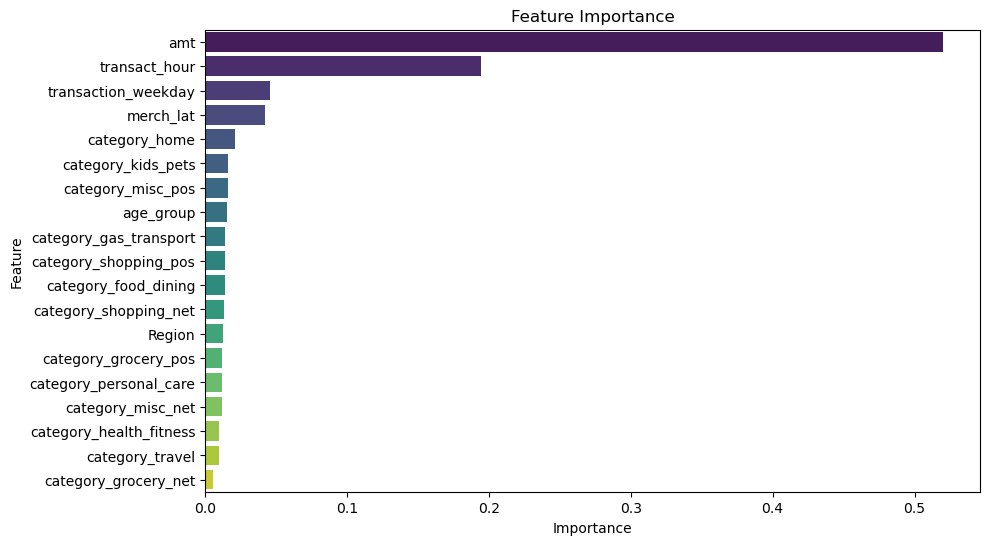

In [50]:
feature_importance = pd.DataFrame({
    'Feature': X_train_smote.columns,
    'Importance': rf_model.feature_importances_
}).sort_values(by='Importance', ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(data=feature_importance, x='Importance', y='Feature', palette="viridis")
plt.title('Feature Importance')
plt.show()

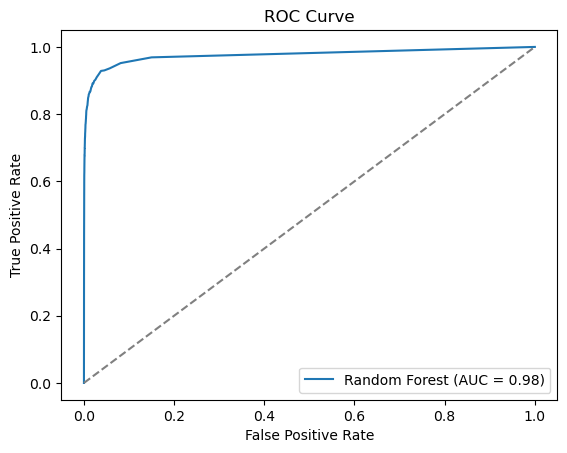

In [51]:
import matplotlib.pyplot as plt

fpr, tpr, _ = roc_curve(y_test, y_pred_prob_rf)  # You Can use model name to get the LR ROC Curve
plt.plot(fpr, tpr, label=f"Random Forest (AUC = {auc_roc_rf:.2f})")
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.show()


Classification Report for Logistic Regression at Threshold 0.2:
              precision    recall  f1-score   support

           0       1.00      0.66      0.79    166072
           1       0.01      0.73      0.02       644

    accuracy                           0.66    166716
   macro avg       0.50      0.69      0.41    166716
weighted avg       0.99      0.66      0.79    166716



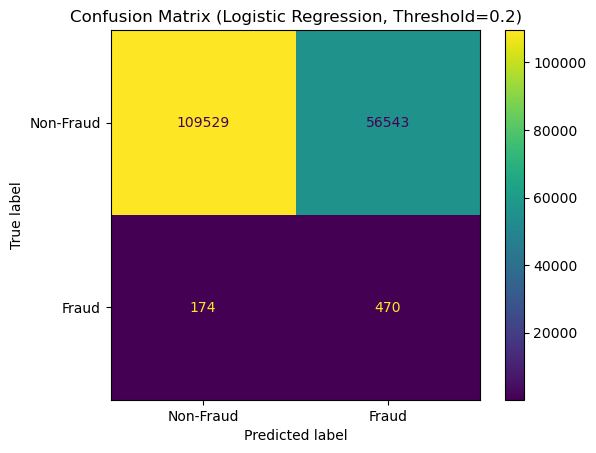

In [52]:
import numpy as np
from sklearn.metrics import precision_recall_curve, roc_auc_score, classification_report, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Generate predicted probabilities
y_pred_prob_lr = lr_model.predict_proba(X_test)[:, 1]

# Evaluate precision, recall, and thresholds
precision, recall, thresholds = precision_recall_curve(y_test, y_pred_prob_lr)

'''
# Plot Precision-Recall vs Threshold
plt.figure(figsize=(10, 6))
plt.plot(thresholds, precision[:-1], label="Precision")
plt.plot(thresholds, recall[:-1], label="Recall")
plt.xlabel("Threshold")
plt.ylabel("Metric Value")
plt.title("Precision-Recall vs Threshold for Logistic Regression")
plt.legend()
plt.show()

'''

# Choose a threshold (e.g., where precision and recall are balanced or based on business priorities)
optimal_threshold_lr = 0.2  # Example: Adjust this based on the graph

# Generate new predictions based on the adjusted threshold
y_pred_lr_tuned = (y_pred_prob_lr > optimal_threshold_lr).astype(int)

# Evaluate metrics with the new threshold
print(f"Classification Report for Logistic Regression at Threshold {optimal_threshold_lr}:")
print(classification_report(y_test, y_pred_lr_tuned))

# Confusion Matrix
ConfusionMatrixDisplay.from_predictions(y_test, y_pred_lr_tuned, display_labels=['Non-Fraud', 'Fraud'], cmap='viridis')
plt.title(f"Confusion Matrix (Logistic Regression, Threshold={optimal_threshold_lr})")
plt.show()


Classification Report for Random Forest at Threshold 0.2:
              precision    recall  f1-score   support

           0       1.00      0.99      0.99    166072
           1       0.25      0.85      0.38       644

    accuracy                           0.99    166716
   macro avg       0.62      0.92      0.69    166716
weighted avg       1.00      0.99      0.99    166716



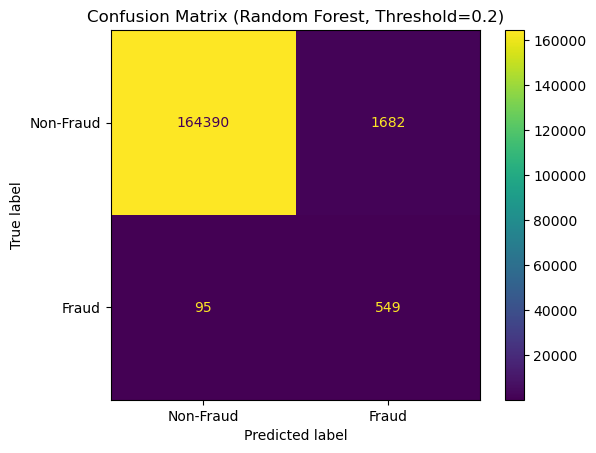

In [53]:

import numpy as np
from sklearn.metrics import precision_recall_curve, roc_auc_score, classification_report, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Generate predicted probabilities
y_pred_prob_rf = rf_model.predict_proba(X_test)[:, 1]

# Evaluate precision, recall, and thresholds
precision_rf, recall_rf, thresholds_rf = precision_recall_curve(y_test, y_pred_prob_rf)

'''
# Plot Precision-Recall vs Threshold
plt.figure(figsize=(10, 6))
plt.plot(thresholds_rf, precision_rf[:-1], label="Precision")
plt.plot(thresholds_rf, recall_rf[:-1], label="Recall")
plt.xlabel("Threshold")
plt.ylabel("Metric Value")
plt.title("Precision-Recall vs Threshold for Random Forest")
plt.legend()
plt.show()

'''

# Choose a threshold (e.g., where precision and recall are balanced or based on business priorities)
optimal_threshold_rf = 0.2 # Example: Adjust this based on the graph

# Generate new predictions based on the adjusted threshold
y_pred_rf_tuned = (y_pred_prob_rf > optimal_threshold_rf).astype(int)

# Evaluate metrics with the new threshold
print(f"Classification Report for Random Forest at Threshold {optimal_threshold_rf}:")
print(classification_report(y_test, y_pred_rf_tuned))

# Confusion Matrix
ConfusionMatrixDisplay.from_predictions(y_test, y_pred_rf_tuned, display_labels=['Non-Fraud', 'Fraud'], cmap='viridis')
plt.title(f"Confusion Matrix (Random Forest, Threshold={optimal_threshold_rf})")
plt.show()
